In [1]:
import numpy as np
import os
import scipy.stats as stats
import scipy.io as io
import networkx as nx
import random
import itertools
import glob
from scipy.stats import linregress
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,roc_curve,roc_auc_score
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from scipy.io import loadmat, savemat
#from fracModel import fracOrdUU
from collections import Counter
from collections import defaultdict
from numpy import arange,array,ones,linalg
from sklearn.linear_model import LinearRegression
import pandas as pd
import powerlaw
import os.path
from os import path
import warnings
warnings.filterwarnings("ignore")
import pickle
import ast

In [2]:
##Calculate entropy
def Entropy_MC(s,b,k,beta,gamma,st_in,l):
    #s = s[st_in:min(st_in+l,len(s))]+s[26000:len(s)]
    s = s[st_in:min(st_in+l,len(s))]
    inv, l, n = k-b, len(s), 4**k
    T=np.zeros((n,n))
    count = [0]*n
    word_list = [''.join(x) for x in itertools.product('acgt', repeat=k)]
    wd = dict(zip(word_list, list(range(len(word_list)))))
    uu = []
    for i in range(k,l-b):
        n1, n2 = wd[s[i-k:i]], wd[s[i-k+b:i+b]]
        T[n1,n2] += 1
        count[n1] += 1
        
    wo_next = [''.join(x) for x in itertools.product('acgt', repeat=b)]
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            T[i,j] = (T[i,j]+beta)/(count[i]+4**b*beta)
    sum_count = np.sum(count)+4**k*gamma
    
    prob = [(count[i]+gamma)/sum_count for i in range(len(count))] 
    n = len(T)
    H = 0
    F = []
    for i in range(n):
        wo = word_list[i]
        for l in wo_next:
            j = wd[wo[b:]+l]
            F.append(T[i,j])
            H-=prob[i]*T[i,j]*np.log2(T[i,j])
    return F,H

In [3]:
from collections import defaultdict
def getSeqs(filename):
    seq_list = defaultdict(list)
    mapseq_list = defaultdict(list)
    mapping = {'A': 'a', 'T': 't', 'C': 'c', 'G': 'g','a': 'a', 't': 't', 'c': 'c', 'g': 'g'}
    with open(filename) as f:
        j = -1
        for i, line in enumerate(f):
            if line.startswith('>'):
                j += 1
            else:
                this_line = list(line)
                this_line = list(filter(lambda ch: ch in 'acgtACGT', this_line))
                seq_list[j].extend(this_line)
                mapseq_list[j] = ''.join(list(map(lambda ch: mapping[ch], seq_list[j])))
    return mapseq_list

In [4]:
def stats(s,b,k,beta,gamma,st_in,l):
    F_list = []
    en_list=[]
    for i in range(len(s)):
        F,en = Entropy_MC(s[i],b,k,beta,gamma,st_in,l) #Transition Probability vector
        F_list.append(F)
        en_list.append(en)
    return F_list,en_list

In [5]:
def data_matrix(V,st_in,l):
    X = []
    ct = 0
    n = len(V)
    print(n)
    G = [[] for i in range(n)]
    st_in = 0
    for seq in V:
        for s in seq:
            F_list,en_list = stats(s,b,k,beta,gamma,st_in,l)
            G[ct]+=F_list
        print(len(G[ct]))
        ct+=1


    


    for i in range(n):
        
        X+=[G[i][j] for j in range(len(G[i]))]
    X = np.array(X)
    X = preprocessing.scale(X)
    print(X.shape)
    return X




3
1818
1732
1622
(5172, 1024)


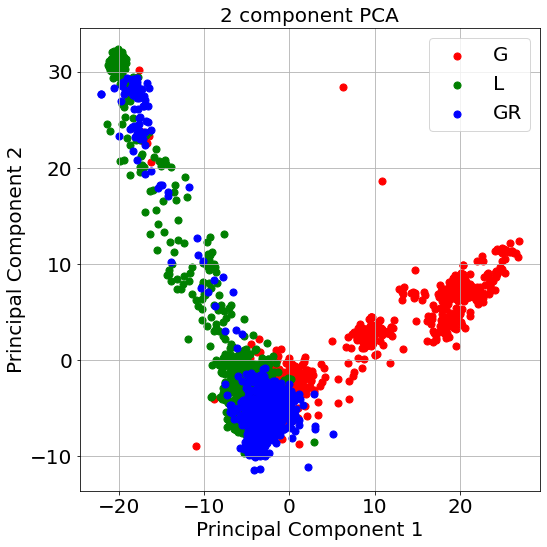

In [6]:
b = 1
k = 4
beta = 0.5
gamma = 0.5
st_in = 0
l = 30000

V = []

plt.rcParams.update({'font.size': 20})

with open('Oct_G.pkl','rb') as g:  
    W = pickle.load(g)
V.append(W[0])
with open('Mar_L.pkl','rb') as g:  
    W = pickle.load(g)
V.append(W[0])
with open('May_GR_F8.pkl','rb') as g:  
    W = pickle.load(g)
V.append(W[0])

X = data_matrix(V,st_in,l)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 20)
ax.set_ylabel('Principal Component 2', fontsize = 20)
ax.set_title('2 component PCA', fontsize = 20)
color = ['red','green','blue','red','orange','pink','violet','orange','black','brown','teal','pink']
targets = ['G','L','GR']
ind = range(len(V))
num_ind = [0]
for i in ind:
    num_ind.append(len(V[i][0])+num_ind[-1])
for i in range(1,len(V)+1):
    ax.scatter(principalDf.loc[num_ind[i-1]:num_ind[i], 'principal component 1']
                   , principalDf.loc[num_ind[i-1]:num_ind[i], 'principal component 2']
                   , c = color[i-1]
                   , s = 50)
ax.legend(targets)
ax.grid()
plt.tight_layout()
fig.savefig('PCA_new_paper_2.png',dpi = 300)